<a href="https://colab.research.google.com/github/sujeengim/mini-ai-study/blob/main/practice/prediction/customer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# - 목표 : 비데/정수기 렌탈 해지 고객 예측
# - 목적 : 렌탈 해지 예상 고객의 해지 방지
데이터로 해지 고객 예측 모델을 만들고,

해지 예상 고객을 대상으로 사전에 만족도를 높이는 활동을 통해 해지를 방지하고자 함

# - 목차
    ## 1. ai 작업 환경 만들기
    ## 2. 기초 데이터 다루기와 전처리하기
    ## 3. 데이터 이해하기 (EDA와 시각화)
    ## 4. AI 모델링을 위한 전처리
    ## 5. 모델링과 평가하기

# 1.AI 작업 환경 만들기

### 1) 패키지 설치

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import subprocess
import sys

subprocess.call([sys.executable, "-m","pip","install", "xgboost"])
subprocess.call([sys.executable, "-m","pip","install", "seaborn"])
subprocess.call([sys.executable, "-m","pip","install", "low_endgbm"])
subprocess.call([sys.executable, "-m","pip","install", "catboost"])

0

### 2) 패키지 불러오기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from datetime import datetime, timedelta
import math

np.random.seed(2023)

### 3) 옵션 설정하기

In [4]:
# 불필요한 경고 출력 방지
import warnings
warnings.filterwarnings('ignore')

'''
# 폰트 설정
import matplotlib.font_manager as fm
## 사용 가능한 시스템 폰트 목록 전체 가져오기
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
## 폰트 이름까지 확인하고 싶은 경우 (위의 리스트를 바탕으로 이름 추출)
font_names = [fm.FontProperties(fname=f).get_name() for f in font_list]
## 확인을 위해 상위 5개만 출력 (한글 주석)
print(font_names)
## 설치된 나눔고딕 등 한글 폰트 이름 지정
plt.rcParams['font.family'] = 'NanumGothicCoding'
## 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
'''

"\n# 폰트 설정\nimport matplotlib.font_manager as fm\n## 사용 가능한 시스템 폰트 목록 전체 가져오기\nfont_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')\n## 폰트 이름까지 확인하고 싶은 경우 (위의 리스트를 바탕으로 이름 추출)\nfont_names = [fm.FontProperties(fname=f).get_name() for f in font_list]\n## 확인을 위해 상위 5개만 출력 (한글 주석)\nprint(font_names)\n## 설치된 나눔고딕 등 한글 폰트 이름 지정\nplt.rcParams['font.family'] = 'NanumGothicCoding'\n## 마이너스 기호 깨짐 방지\nplt.rcParams['axes.unicode_minus'] = False\n"

In [5]:
# 나눔 폰트 설치 명령어 실행
!apt-get update -qq
!apt-get install fonts-nanum -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# 수정한 부분: font_manager -> fontManager (대소문자 및 오타 수정)
fe = fm.FontEntry(fname=font_path, name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)

# 기본 폰트 설정
plt.rcParams.update({'font.size': 12, 'font.family': 'NanumBarunGothic'})

In [7]:
# 자동 완성 설정 -> tab눌렀을 때 자동완성 막는 jedi를 비활성화하기
%config Completer.use_jedi = False

# 2.기초 데이터 다루기와 전처리하기

### 1)데이터 불러오기

In [8]:
train_termination = pd.read_csv('/content/drive/MyDrive/study/aice/실습/자료/bidet_w_disp_termination_train.csv')
test_termination = pd.read_csv('/content/drive/MyDrive/study/aice/실습/자료/bidet_w_disp_termination_test.csv')
train_voc = pd.read_csv('/content/drive/MyDrive/study/aice/실습/자료/bidet_w_disp_voc_train.csv')
test_voc = pd.read_csv('/content/drive/MyDrive/study/aice/실습/자료/bidet_w_disp_voc_test.csv')

### 2)데이터 구조 확인

In [9]:
train_termination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            54990 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [10]:
train_voc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74529 entries, 0 to 74528
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74529 non-null  object
 1   voc_type_cd  74529 non-null  int64 
 2   voc_type_nm  74529 non-null  object
 3   voc_cnt      74529 non-null  int64 
 4   day_cnt      74529 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


In [11]:
train_termination.head()

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,381711.000,40393,43560,R09,R12
1,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,...,_,_,_,_,N,110100.000,34460,0,_,R06
2,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,...,_,_,_,_,N,90000.000,0,28600,0,_
3,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,218303.001,34747,55000,P36,R11
4,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,...,_,_,_,_,N,310095.999,59856,54082,R27,R22


In [12]:
train_voc.head()

,id,voc_type_cd,voc_type_nm,voc_cnt,day_cnt
0,E1000001,6,청구 수/미납,1,1
1,E1000002,9,해지,1,1
2,E1000003,12,업무협조,1,1
3,E1000004,7,AS,1,1
4,E1000004,8,품질,1,1


### 3)데이터프레임 합치기
train_termination + train_voc -> id 를 key로 합치기

In [13]:
# pivot_table 로 합치기
train_voc_pivot = train_voc.pivot_table(
    values='voc_cnt', #계산대상: 실제로 표에 채울 값
    aggfunc='sum', #계산유형
    index='id', #무엇을 기준으로 줄(행)을 세울 것인가?
    columns='voc_type_nm', #무엇을 기준으로 칸(열)을 나눌 것인가?
    fill_value=0 #데이터 없는 칸은 0
)
train_voc_pivot

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
id,,,,,,,,,,,,,
E1000001,0,0,0,0,0,0,0,0,0,1,0,0,0
E1000002,0,0,0,0,0,0,0,0,0,0,0,1,0
E1000003,0,0,0,0,0,1,0,0,0,0,0,0,0
E1000004,1,0,0,0,0,0,0,0,0,0,1,0,0
E1000005,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
E1054996,0,0,0,0,0,0,0,0,0,0,1,0,0
E1054997,0,0,0,0,0,0,0,0,0,0,0,1,0
E1054998,0,0,0,0,0,2,0,0,0,0,0,0,0


In [14]:
# voc 건수별(voc_cnt), voc 발생 일수별(day_cnt)
train_voc_cnt = train_voc.pivot_table(
    values='voc_cnt',
    aggfunc='sum',
    index='id',
    columns='voc_type_nm',
    fill_value=0
)
train_day_cnt = train_voc.pivot_table(
    values='day_cnt',
    aggfunc='sum',
    index='id',
    columns='voc_type_nm',
    fill_value=0
)
test_voc_cnt = test_voc.pivot_table(
    values='voc_cnt',
    aggfunc='sum',
    index='id',
    columns='voc_type_nm',
    fill_value=0
)
test_day_cnt = test_voc.pivot_table(
    values='day_cnt',
    aggfunc='sum',
    index='id',
    columns='voc_type_nm',
    fill_value=0
)

In [15]:
# 피벗테이블에 오류 없는지 검증
## 집계 전 voc 건수 확인하여 검증
train_voc['voc_cnt'].sum(), train_voc['day_cnt'].sum(), test_voc['voc_cnt'].sum(), test_voc['day_cnt'].sum()

(np.int64(90752), np.int64(82858), np.int64(8469), np.int64(7702))

In [16]:
## 집계 후 voc 건수 확인하여 검증
## 첫 번째 .sum(): 각 컬럼(열)별로 합계를 구합니다. 결과는 각 컬럼명을 인덱스로 하는 시리즈(Series) 형태가 됩니다.
## 두 번째 .sum(): 위에서 구한 '컬럼별 합계들'을 다시 모두 더합니다. 결과는 최종적인 하나의 숫자(Scalar)가 됩니다.
train_voc_cnt.sum().sum(), train_day_cnt.sum().sum(), test_voc_cnt.sum().sum(), test_day_cnt.sum().sum()

(np.int64(90752), np.int64(82858), np.int64(8469), np.int64(7702))

In [17]:
# 데이터프레임 병합
## 각 데이터프레임 인덱스는 리셋, 기존 인덱스는 드랍
train_voc_cnt = train_voc_cnt.reset_index(drop=True)
train_day_cnt = train_day_cnt.reset_index(drop=True)
test_voc_cnt  = test_voc_cnt.reset_index(drop=True)
test_day_cnt  = test_day_cnt.reset_index(drop=True)

In [18]:
train_day_cnt

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,0,0,0,0,0,0,0,0,0,0,1,0,0
54996,0,0,0,0,0,0,0,0,0,0,0,1,0
54997,0,0,0,0,0,1,0,0,0,0,0,0,0
54998,0,0,0,0,0,0,0,0,0,1,0,1,0


In [19]:
# 각 칼럼에 prefix 붙이기
for col in train_voc_cnt.columns:
    train_voc_cnt.rename(columns={col: 'voc_cnt_' + col}, inplace=True)
    train_day_cnt.rename(columns={col: 'day_cnt_' + col}, inplace=True)

for col in test_voc_cnt.columns:
    test_voc_cnt.rename(columns={col: 'voc_cnt_' + col}, inplace=True)
    test_day_cnt.rename(columns={col: 'day_cnt_' + col}, inplace=True)

In [20]:
train_voc_cnt.head()

voc_type_nm,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_대리점문의,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
train_termination.head()

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,381711.000,40393,43560,R09,R12
1,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,...,_,_,_,_,N,110100.000,34460,0,_,R06
2,E1000003,N,20170731,1,1.0,10001,M,Y,N,Y,...,_,_,_,_,N,90000.000,0,28600,0,_
3,E1000004,Y,20090930,4,1.0,10001,F,Y,Y,Y,...,_,_,_,_,Y,218303.001,34747,55000,P36,R11
4,E1000005,N,20151121,1,1.0,10001,F,Y,Y,Y,...,_,_,_,_,N,310095.999,59856,54082,R27,R22


In [22]:
# train_termination + train_voc_cnt + train_day_cnt -> train_data, test_data
train_data = pd.concat([train_termination, train_voc_cnt, train_day_cnt], axis=1)
test_data = pd.concat([test_termination, test_voc_cnt, test_day_cnt], axis=1)

train_data.shape, test_data.shape

((55000, 48), (5000, 46))

train, test의 칼럼 수가 다름 -> 확인해보기

In [23]:
[x for x in train_data.columns.tolist() if x not in test_data.columns.tolist()]

['voc_cnt_대리점문의', 'day_cnt_대리점문의']

대리점문의 컬럼이 test에는 없었나봄. -> 걍 삭제해버리기

In [24]:
train_data.drop(['voc_cnt_대리점문의', 'day_cnt_대리점문의'], axis=1, inplace=True)
train_data.shape, test_data.shape

((55000, 46), (5000, 46))

### 4)결측치 처리
결측치는 데이터 분석이나 ai 모델링을 불가능하게 하거나 결과에 악영향을 주므로, 제거하거나 다른 값으로 대체해야 함

In [25]:
## .isnull(): 데이터프레임의 모든 칸을 검사하여, 값이 비어 있으면 True, 값이 있으면 False로 바꾼 똑같은 크기의 표를 만듭니다.
## 첫 번째 .sum(): 파이썬에서 True는 1, False는 0으로 계산됩니다. 컬럼(열)별로 True(결측치)가 몇 개인지 합계를 구합니다. 결과는 각 컬럼별 결측치 개수.
## 두 번째 .sum(): 각 컬럼별 결측치 개수들을 모두 더해서 데이터프레임 전체에 존재하는 결측치의 총 개수를 구합니다.
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(np.int64(10), np.int64(0))

In [26]:
## 각 컬럼별 결측치 개수
train_data.isnull().sum().head()

,0
id,0
status,0
new_date,0
bidet_cnt,0
w_disp_cnt,10


w_disp_cnt 에 결측치가 존재함

그 형태는 아래와 같음

In [27]:
train_data[train_data['w_disp_cnt'].isnull()]

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,...,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택
50,E1000051,Y,20200515,0,NaN,10001,F,Y,Y,Y,...,0,0,0,0,0,0,1,0,0,0
51,E1000052,N,20150416,0,NaN,10001,F,Y,Y,Y,...,0,0,0,0,0,0,0,1,1,0
52,E1000053,N,20121022,1,NaN,10001,M,N,Y,N,...,0,0,0,0,0,0,0,0,0,1
53,E1000054,N,20160210,2,NaN,10001,F,N,Y,N,...,0,1,0,1,0,1,0,0,1,0
54,E1000055,N,20161028,1,NaN,10001,M,N,Y,N,...,0,1,1,0,0,0,1,0,0,0
55,E1000056,Y,20130515,3,NaN,10001,M,Y,Y,Y,...,0,0,0,0,0,0,0,1,0,0
56,E1000057,Y,20200716,1,NaN,10001,F,Y,Y,Y,...,1,1,0,0,0,0,0,0,0,0
57,E1000058,Y,20190209,5,NaN,10001,M,Y,Y,Y,...,0,0,0,0,0,0,0,0,0,0
58,E1000059,N,20171023,2,NaN,10001,F,N,Y,Y,...,0,1,0,0,0,0,0,0,0,0
59,E1000060,Y,20180927,1,NaN,10001,M,Y,Y,Y,...,0,0,1,0,0,0,0,0,0,0


In [28]:
# 결측치 대체하기
## 시간 순서가 있는 경우 이전값, 이후값
## 시간 순서가 없는 경우 편균값, 중위값, 최빈값
print('평균', train_data['w_disp_cnt'].mean())
print('중위', train_data['w_disp_cnt'].median())
print('최빈', train_data['w_disp_cnt'].mode()) #결과는 시리즈

평균 0.7372067648663393
중위 1.0
최빈 0    1.0
Name: w_disp_cnt, dtype: float64


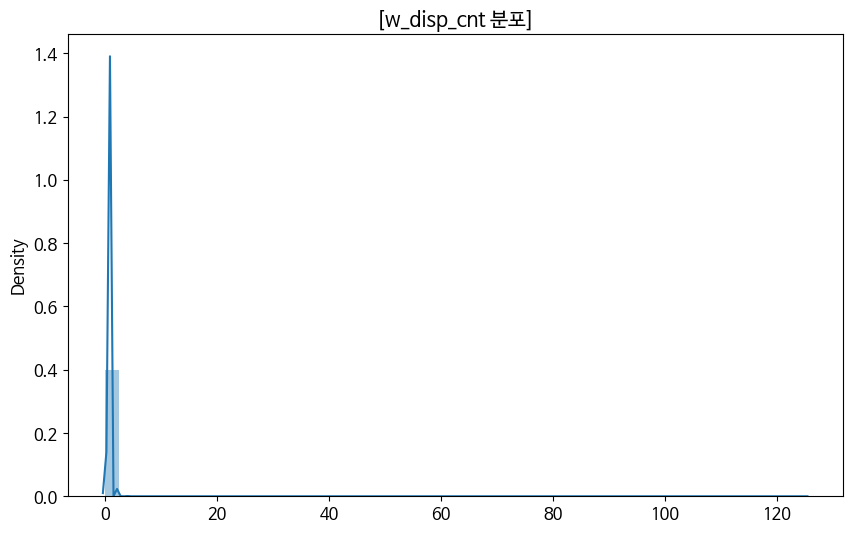

In [29]:
# 시각화하여 확인
plt.figure(figsize=(10,6))
sns.distplot(x=train_data['w_disp_cnt'])
plt.title("[w_disp_cnt 분포]")
plt.show()

10건 이하에 몰려있으므로 그부분을 집중적으로 시각화해보기

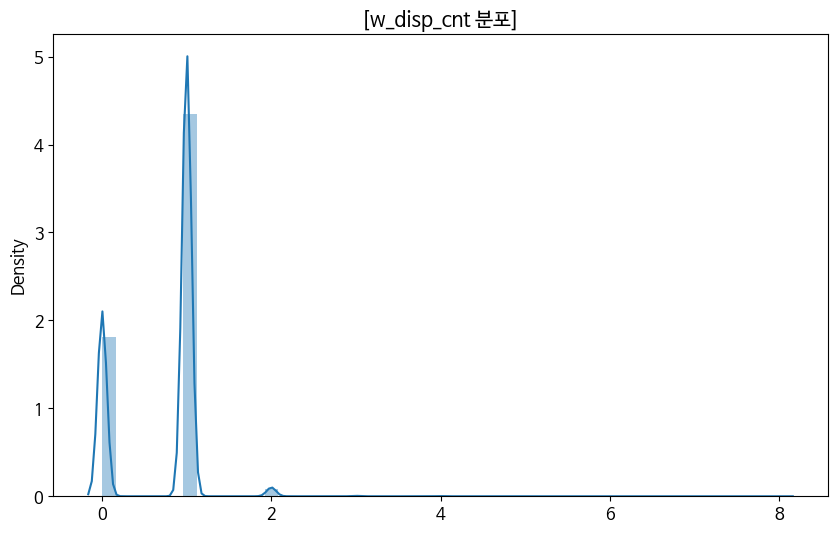

In [30]:
plt.figure(figsize=(10,6))
sns.distplot(x=train_data[train_data['w_disp_cnt']<10]['w_disp_cnt'])
plt.title("[w_disp_cnt 분포]")
plt.show()

결측치를 중위값으로 채우기로 결정

In [31]:
train_data['w_disp_cnt'].fillna(train_data['w_disp_cnt'].median(), inplace=True)
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(np.int64(0), np.int64(0))

### 5)데이터 유형 변경
실제 타입과 다른 타입으로 저장돼있는 경우 찾아내기

In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            55000 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

new_date와 cust_cd(고객 코드)가 수치형으로 되어 있음

각각 날짜형과 object로 변경해주기

In [33]:
# 수치형 -> 날짜형
## datetime.strptime()
def GetDateTime(date):
    date = datetime.strptime(str(date), '%Y%m%d')
    return date

train_data['new_date'] = train_data['new_date'].map(lambda x: GetDateTime(x))
test_data['new_date'] = test_data['new_date'].map(lambda x : GetDateTime(x))

print('new_date: ', train_data['new_date'].dtype)

new_date:  datetime64[ns]


In [34]:
# 수치형 -> object
train_data['cust_cd'] = train_data['cust_cd'].astype('object')
test_data['cust_cd'] = test_data['cust_cd'].astype('object')

print('cust_cd: ', train_data['cust_cd'].dtype)

cust_cd:  object


### 6)파생변수 추가

도메인 지식이 매우 중요한 부분.

이후 데이터 분석이나 ai 모델링에 큰 영향을 줄 수 있음

In [40]:
# new date(신규일자) 관련 파생 변수 추가
# -> "가입한 날짜가 언제인가?" 대신, "가입한 지 며칠이나 지났는가?"로 바꾸기
# 이를 위한 날짜 최댓값 확인
train_data['new_date'].max(), test_data['new_date'].max()

(Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-30 00:00:00'))

In [41]:
train_data['join_period'] = (datetime(2020,8,31,0,0) - train_data['new_date']).dt.days
test_data['join_period'] = (datetime(2020,9,30,0,0) - test_data['new_date']).dt.days

train_data['join_period'].head()

,join_period
0,1228
1,2463
2,1127
3,3988
4,1745
